In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler

In [11]:
artists_dataset = pd.read_csv('dataset/tabular/artists_cleaned.csv')
tracks_dataset = pd.read_csv('dataset/tabular/tracks_cleaned.csv')

In [17]:
tracks_dataset

,id,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,...,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_beats,n_bars,genre,year,month,day
0,45OX2jjEw1l7lOFJfDP9fv,MONEY,168227,False,95,LISA,LALISA,0.826,0.55300,1,...,0.789,0.989,0.043,0.253,381.0,95.0,"['k-pop', 'pop']",2021,9.0,10.0
1,5XeFesFbtLpXzIVDNQP22n,I Wanna Be Yours,183956,False,94,Arctic Monkeys,AM,0.464,0.41700,0,...,0.097,1.000,0.545,0.533,202.0,50.0,"['indie', 'garage', 'rock']",2013,9.0,9.0
2,2bRKxuH1o7pTmb1y4GfdEc,Clean White Noise - Loopable with no fade,90228,False,94,White Noise Baby Sleep;White Noise for Babies,Best White Noise for Baby Sleep - Loopable wit...,0.000,0.00342,8,...,0.000,0.000,0.000,0.116,0.0,0.0,['sleep'],2017,1.0,8.0
3,4uUG5RXrOk84mYEfFvj3cK,I'm Good (Blue),175238,True,94,David Guetta;Bebe Rexha,I'm Good (Blue),0.561,0.96500,7,...,0.808,0.789,0.898,0.773,368.0,91.0,['pop'],2022,8.0,26.0
4,0WtM2NBVQNNJLh6scP13H8,Calm Down (with Selena Gomez),239317,False,93,Rema;Selena Gomez,Calm Down (with Selena Gomez),0.801,0.80600,11,...,0.492,1.000,0.593,0.597,424.0,105.0,['pop'],2022,8.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81220,1nSYUQngGS5foiagiilbYU,Singles You Up,182693,False,0,Jordan Davis,Mientras hago aromaterapia,0.634,0.90300,7,...,0.137,1.000,0.439,0.533,296.0,74.0,['country'],2022,10.0,14.0
81221,1nU1tlW9ccptgRLfgq05I3,"Schlagzeile groß, Hirn zu klein",255093,False,0,Frei.Wild,Feinde deiner Feinde (Gold Edition),0.412,0.98400,8,...,0.120,0.762,0.558,0.509,818.0,205.0,['german'],2013,4.0,19.0
81222,72ZHywsIxzF1ZkNlMyhsqt,"Ding! Dong! The Witch Is Dead (From ""The Wizar...",179035,False,0,The Countdown Kids,Happy Halloween! (Spooky Favorites for Kids),0.741,0.93700,11,...,0.826,0.959,0.715,0.532,352.0,87.0,['children'],2022,10.0,14.0
81223,5Wt0gIt7RrXz5mJj5pslLC,Zenitsu Theme V2 (Thunder Clap and Flash!),137948,False,0,Samuel Kim,Demon Slayer: Epic Collection,0.507,0.80300,0,...,0.545,1.000,0.791,0.703,263.0,67.0,['anime'],2021,5.0,21.0


In [12]:
artists_dataset

,id,name,popularity,followers,genres
0,06HL4z0CvFAxyc27GXpf02,Taylor Swift,100.0,82377431.0,['pop']
1,3TVXtAsR1Inumwj472S9r4,Drake,94.0,78233981.0,"['canadian hip hop', 'canadian pop', 'hip hop'..."
2,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,94.0,69417099.0,"['canadian contemporary r&b', 'canadian pop', ..."
3,4q3ewBCX7sLwd24euuV69X,Bad Bunny,94.0,72659297.0,"['reggaeton', 'trap latino', 'urbano latino']"
4,0Y5tJX1MQlPlqiwlOH1tJY,Travis Scott,94.0,23519791.0,"['hip hop', 'rap', 'slap house']"
...,...,...,...,...,...
29962,1qLPQciZ1gRoYAd5zusgGe,Martina Rudic,0.0,12.0,[]
29963,4V8YX6UEzcFLmHUh2HfJux,Jean-Philippe Audin,0.0,12.0,[]
29964,4u7SioU0plZ0L4kBCEdj47,Alexei Kuzmin,0.0,4.0,[]
29965,2vh8ZeDiygDZkW4JUtgRwH,Azhirock,0.0,194.0,['iranian metal']


In [13]:
# print duplicated names
duplicated_names = artists_dataset[artists_dataset.duplicated('name', keep=False)]
duplicated_names

,id,name,popularity,followers,genres
482,3CJKkU0XuElRT1z8rEtIYg,Luciano,72.0,1915232.0,"['german drill', 'german hip hop']"
1161,58oPVy7oihAEXE0Ott6JOf,Eve,66.0,2027404.0,"['anime', 'anime rock']"
1251,1YOVBTvznjiDvtAj4ExHeo,BK,66.0,1134592.0,['brazilian hip hop']
1373,77iZVjeYoYSl5P0K9mIiUE,Haze,65.0,10611.0,['latin pop']
1378,1bqxdqvUtPWZri43cKHac8,MAX,65.0,828080.0,"['singer-songwriter pop', 'viral pop']"
...,...,...,...,...,...
26863,32GL3p1axBHhJQfQ4MUD6y,Steve Hill,14.0,2661.0,"['hard dance', 'hard house']"
28389,0e1xN832756AiKLVqLEKns,Carl Craig,7.0,2210.0,['intelligent dance music']
29179,4wPVF3nMOZ9jbQgE1EmQGi,Level,3.0,91.0,['australian hardcore']
29473,1j34sa4N2cHy7iYJrxznCR,Calibre,1.0,556.0,['iranian metal']


# Data Exploration

## Artists Dataset

### Data exploration

In [55]:
artists_dataset.describe()

,popularity,followers
count,30088.000000,3.008800e+04
mean,36.692402,4.171364e+05
std,17.212396,2.485316e+06
min,0.000000,0.000000e+00
25%,25.000000,1.488750e+03
50%,37.000000,1.588950e+04
75%,49.000000,1.191090e+05
max,100.000000,1.141635e+08


In [56]:
# Now let's check if we have duplicate names
duplicated_rows = artists_dataset[artists_dataset.duplicated('name', keep=False)]
duplicated_rows

,id,name,popularity,followers,genres
241,2jSGzJw0ebJLu7OLVSOcBP,Plan B,77.0,3265393.0,"['reggaeton', 'trap latino', 'urbano latino']"
293,4W12lEvVl5wectUtRNrvDh,White Noise Baby Sleep,75.0,31191.0,['sleep']
298,4fEkbug6kZzzJ8eYX6Kbbp,KK,75.0,12587568.0,"['filmi', 'modern bollywood']"
338,1wxPItEzr7U7rGSMPqZ25r,Shiloh Dynasty,75.0,1609334.0,"['lo-fi chill', 'sad lo-fi']"
482,3CJKkU0XuElRT1z8rEtIYg,Luciano,72.0,1915232.0,"['german drill', 'german hip hop']"
...,...,...,...,...,...
29836,6qp3DqptxGnT0LAjM71V8B,Fery,0.0,2780.0,['anime lo-fi']
29865,6J6xE014tm1XdKAzOYbOkL,Marley Carroll,0.0,1.0,[]
29874,3ggp4QNbijnG11uuPMVQ0v,Smartface,0.0,11.0,[]
29914,41tlGPBvFWRfo0lU6PZEcF,Shiloh Dynasty,0.0,13240.0,[]


We have 337 rows with duplicated names, hence we have two possibilities: 
- Dropping the rows with duplicated names
- Keeping the rows with duplicated names
- Keeping the rows with duplicated names and merging the popularity, followers and genres columns

In the data preparation phase, we will decide which approach to take.

In [57]:
# Check if we have duplicated ids
duplicated_ids = artists_dataset[artists_dataset.duplicated('id', keep=False)]
duplicated_ids

,id,name,popularity,followers,genres


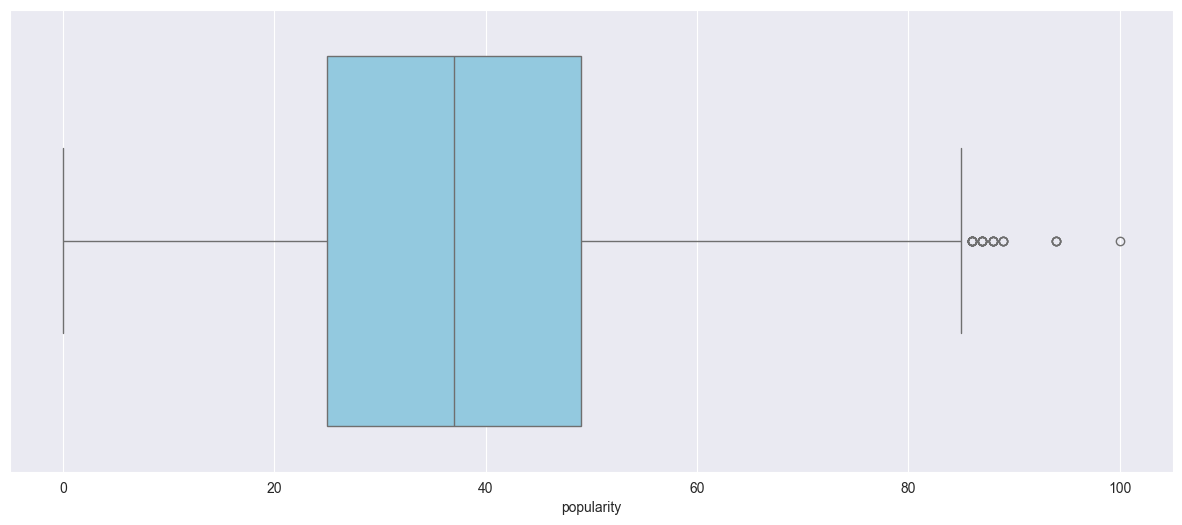

In [58]:
#check for outliers in the popularity column with boxplots
plt.figure(figsize=(15, 6))
sns.boxplot(x=artists_dataset['popularity'], color='skyblue')
plt.show()

In [59]:
# Print the rows with popularity greater than 80
artists_dataset[artists_dataset['popularity'] > 80]

,id,name,popularity,followers,genres
0,06HL4z0CvFAxyc27GXpf02,Taylor Swift,100.0,82377431.0,['pop']
1,3TVXtAsR1Inumwj472S9r4,Drake,94.0,78233981.0,"['canadian hip hop', 'canadian pop', 'hip hop'..."
2,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,94.0,69417099.0,"['canadian contemporary r&b', 'canadian pop', ..."
3,4q3ewBCX7sLwd24euuV69X,Bad Bunny,94.0,72659297.0,"['reggaeton', 'trap latino', 'urbano latino']"
4,0Y5tJX1MQlPlqiwlOH1tJY,Travis Scott,94.0,23519791.0,"['hip hop', 'rap', 'slap house']"
...,...,...,...,...,...
102,0C8ZW7ezQVs4URX5aX7Kqx,Selena Gomez,81.0,44210760.0,"['pop', 'post-teen pop']"
103,2IMZYfNi21MGqxopj9fWx8,Rels B,81.0,5576656.0,"['r&b en espanol', 'spanish hip hop', 'trap la..."
104,5Pwc4xIPtQLFEnJriah9YJ,OneRepublic,81.0,16047137.0,"['piano rock', 'pop']"
105,4SsVbpTthjScTS7U2hmr1X,Arcángel,81.0,11662949.0,"['latin hip hop', 'reggaeton', 'trap latino', ..."


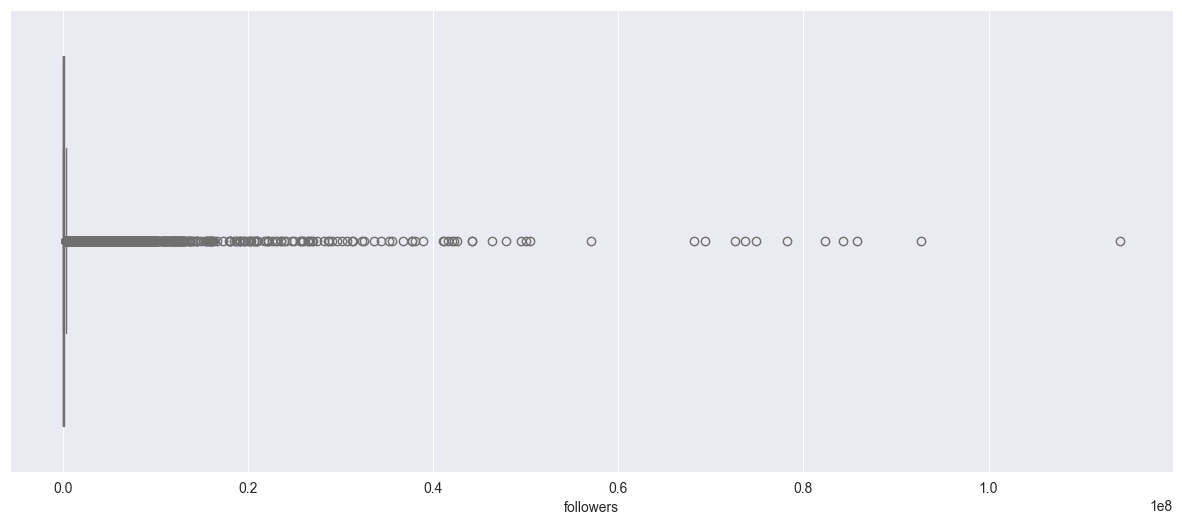

In [60]:
#check for outliers in the followers column with boxplots
plt.figure(figsize=(15, 6))
sns.boxplot(x=artists_dataset['followers'], color='skyblue')
plt.show()

#### Checking and handling missing values

In [62]:
# Check for missing values
artists_dataset.isnull().sum()

id            0
name          0
popularity    0
followers     0
genres        0
dtype: int64

In [63]:
# check for duplicated rows
artists_dataset.duplicated().sum()

0

I'd say to drop the duplicated rows, and the rows that has NaN values in the name column.

### Distribution of variables

Let's start by analyzing the distribution of the popularity variable.

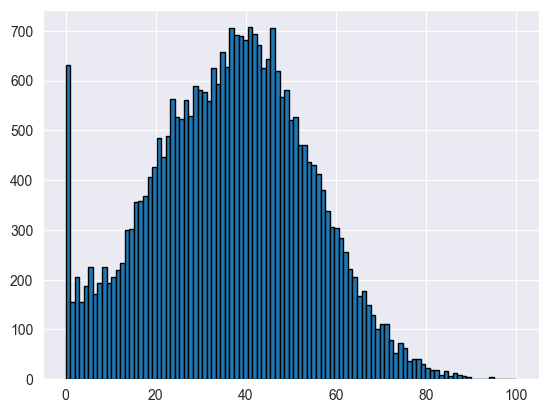

In [64]:
# Define the number of bins you want
num_bins = 100

# Create equal-sized bins using numpy's linspace function
bins = np.linspace(start=min(artists_dataset['popularity']), stop=max(artists_dataset['popularity']), num=num_bins)

# Plot the histogram with the defined bins
plt.hist(artists_dataset['popularity'], bins=bins, edgecolor='black')

# Show the plot
plt.show()

In [65]:
# How many values are in each bin
pd.cut(artists_dataset['popularity'], bins=bins).value_counts()

popularity
(40.404, 41.414]    707
(36.364, 37.374]    705
(45.455, 46.465]    705
(41.414, 42.424]    694
(37.374, 38.384]    691
                   ... 
(94.949, 95.96]       0
(95.96, 96.97]        0
(96.97, 97.98]        0
(97.98, 98.99]        0
(89.899, 90.909]      0
Name: count, Length: 99, dtype: int64

In [66]:
# Number of rows with popularity ranging from 0 to 5
artists_dataset[(artists_dataset['popularity'] >= 0) & (artists_dataset['popularity'] <= 5)]

,id,name,popularity,followers,genres
28751,1L49KERTIyZ2xNqfKvYNjX,Lucky Rabbit,5.0,374.0,[]
28752,0lymTtMXrLPWjWXcjvtc7e,Sami Aarva,5.0,14.0,[]
28753,5l553mDGF8G6UlILJzpfRS,David Stivender,5.0,6.0,[]
28754,33t1sk0KBtX3FxfAyWsSkc,cacique'97,5.0,1354.0,['afrobeat fusion']
28755,0YHkLrAH0UrZ3H7WMFdDgh,Kevin Irving,5.0,339.0,['chicago house']
...,...,...,...,...,...
30083,1qLPQciZ1gRoYAd5zusgGe,Martina Rudic,0.0,12.0,[]
30084,4V8YX6UEzcFLmHUh2HfJux,Jean-Philippe Audin,0.0,12.0,[]
30085,4u7SioU0plZ0L4kBCEdj47,Alexei Kuzmin,0.0,4.0,[]
30086,2vh8ZeDiygDZkW4JUtgRwH,Azhirock,0.0,194.0,['iranian metal']


We can see that we are dealing mainly with artists that have a popularity score between 33 and 44, followed by artists with popularity score between 22 and 33, and with only 201 artists ranging from 77 to 100. Also we have many artists (451) with popularity score of 0 and 1355 artists ranging form 0 to 5. 

The **distribution** is almost symmetrical, the distribution peaks around the median popularity score, which is close to the mean popularity score, indicative of a more balanced distribution compared to the followers. 

Now let's analyze the distribution of the followers variable.

In [83]:
# How many artists have 0 followers
num_artists_no_followers = artists_dataset[artists_dataset['followers'] == 0].shape[0]
num_artists_no_followers

115

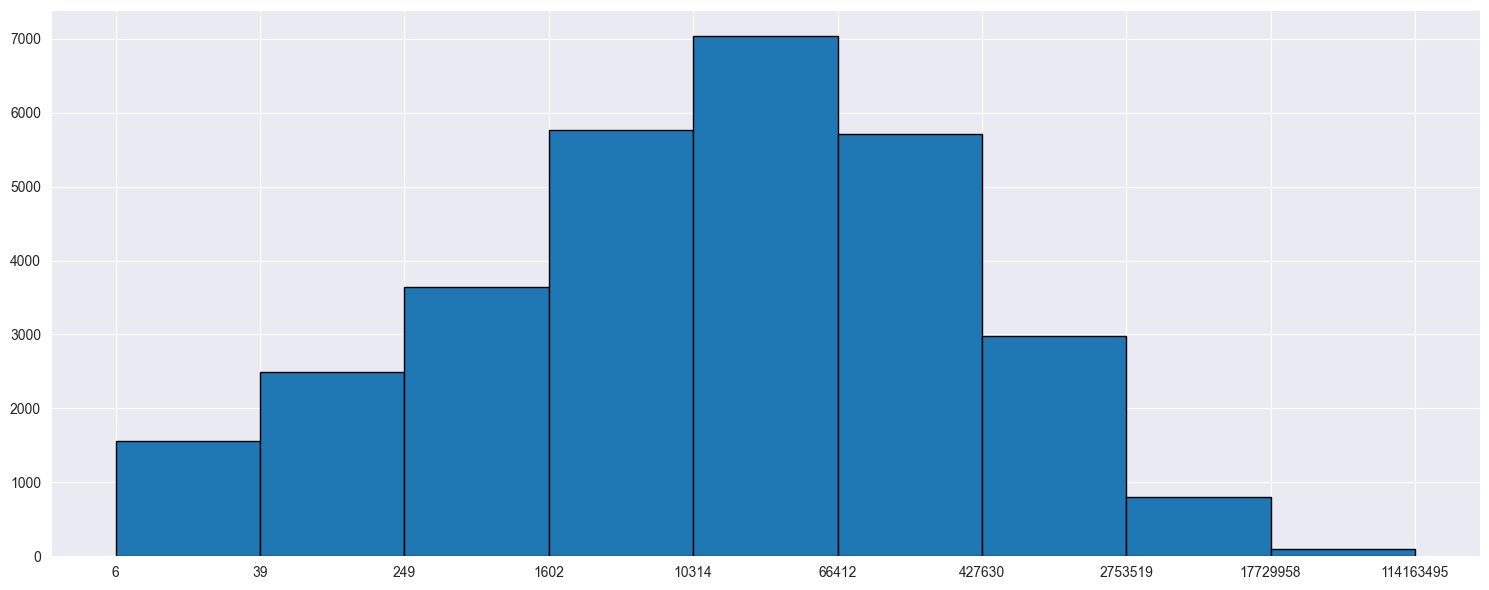

In [89]:
# Add a small constant to avoid taking log of zero
artists_dataset['followers'] += 1
num_bins = 10
log_bins = np.logspace(np.log10(min(artists_dataset['followers'])), np.log10(max(artists_dataset['followers'])), num=num_bins)

# Plot the histogram with logarithmic bins
plt.figure(figsize=(15, 6))
plt.hist(artists_dataset['followers'], bins=log_bins, edgecolor='black')
plt.xscale('log')  # Set x-axis to logarithmic scale

# Set the x-axis to have ticks at the bin edges
plt.gca().xaxis.set_major_locator(ticker.FixedLocator(log_bins))  # Use FixedLocator to set the ticks

# Create custom tick labels for the bins
def custom_fmt(x, pos):
    return '{:.0f}'.format(x)

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(custom_fmt))

# Improve the layout
plt.tight_layout()

# Show the plot
plt.show()

In [90]:
# How many values are in each bin
pd.cut(artists_dataset['followers'], bins=log_bins).value_counts()

followers
(10314.056, 66412.378]         7036
(1601.806, 10314.056]          5770
(66412.378, 427630.416]        5712
(248.766, 1601.806]            3645
(427630.416, 2753519.418]      2978
(38.634, 248.766]              2489
(6.0, 38.634]                  1447
(2753519.418, 17729957.707]     803
(17729957.707, 114163495.0]      93
Name: count, dtype: int64

We can see that, as expected the majority of artist has a small number of followers: the variable has a mean of approximately 416,866 and a median of 15,814 which suggests a right-skewed distribution, this also is confirmed by the histogram. The distributions of followers is heavily skewed, with a few artists having a very high number of followers and the majority having a relatively low number of followers. 

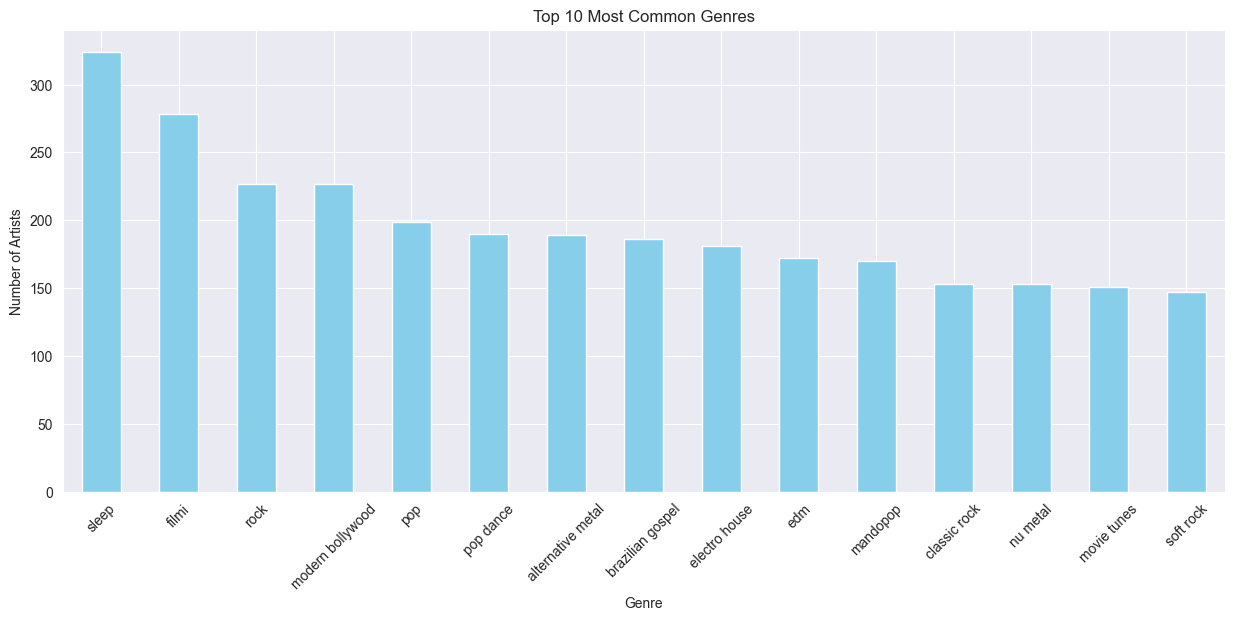

In [92]:
# Now let's check the distribution of the genres

# Split the genres column into a list of genres
genres = artists_dataset['genres'].str.split(',')

# Flatten the list of genres
flattened_genres = [genre for sublist in genres for genre in sublist]

# Create a pandas Series from the flattened list of genres
genres_series = pd.Series(flattened_genres)

# Remove ''' or '[] from the genres
genres_series = genres_series.str.replace('[', '').str.replace(']', '').str.replace("'", '').str.replace("\"",'').str.strip()

# Remove empty strings
genres_series = genres_series[genres_series != '']

# Removed strings with only spaces
genres_series = genres_series[genres_series != ' ']

# Count the occurrences of each genre
genre_counts = genres_series.value_counts()

# Plot the top 10 most common genres
genre_counts.head(15).plot(kind='bar', figsize=(15, 6), color='skyblue')

# Set the title and labels
plt.title('Top 10 Most Common Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Artists')
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
# Show the plot
plt.show()

In data preparation we could split the genres column into multiple columns, one for each genre.

In [69]:
# Count the number of unique genres in the dataset
num_unique_genres = genres_series.nunique()
num_unique_genres

4074

In [70]:
# Count the number of occurrences of each genre
genre_counts

sleep               324
filmi               278
rock                227
modern bollywood    227
pop                 199
                   ... 
nice indie            1
slam death metal      1
kindermusik           1
dutch prog            1
school ensemble       1
Name: count, Length: 4074, dtype: int64

I'd say that this 'filmi' genre is a typo, and it should be 'film' genre. In dataprepation phase we will fix this typo.

In [71]:
# Count the number of artists with no listed genres
num_artists_no_genres = artists_dataset[artists_dataset['genres'] == '[]'].shape[0]
num_artists_no_genres

7512

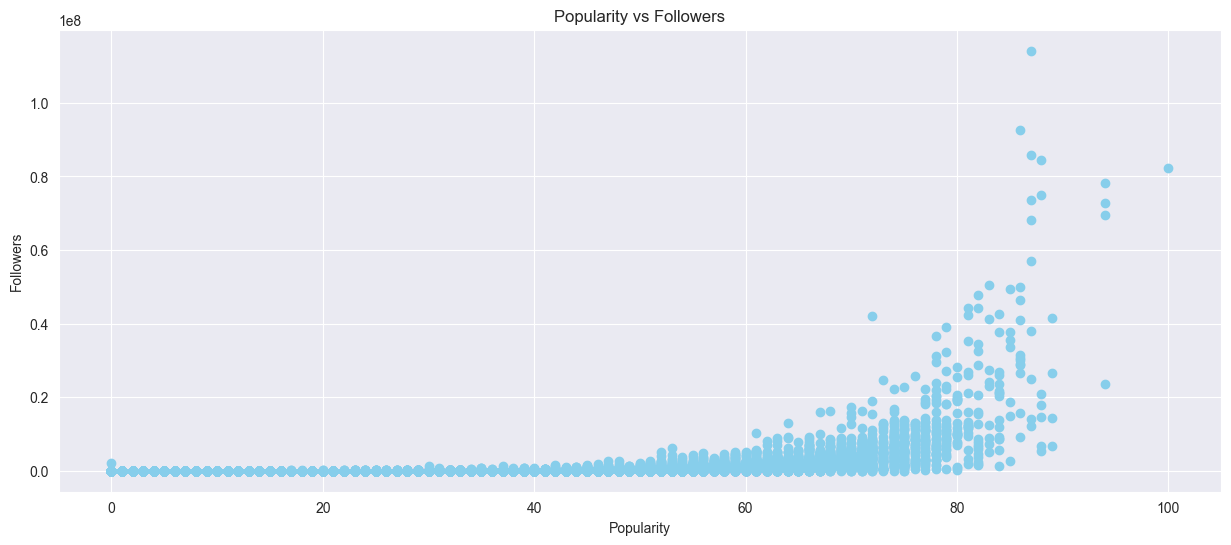

In [93]:
#Scatter plot of popularity vs followers
plt.figure(figsize=(15, 6))
plt.scatter(artists_dataset['popularity'], artists_dataset['followers'], color='skyblue')
plt.xlabel('Popularity')
plt.ylabel('Followers')
plt.title('Popularity vs Followers')

In [107]:
scaler = MinMaxScaler()

# create a dataset with only popularity and followers columns, normalized with min-max scaling

artists_dataset['popularity'] = scaler.fit_transform(artists_dataset['popularity'].values.reshape(-1,1))
artists_dataset['followers'] = scaler.fit_transform(artists_dataset['followers'].values.reshape(-1,1))

Text(0.5, 1.0, 'Popularity vs Followers')

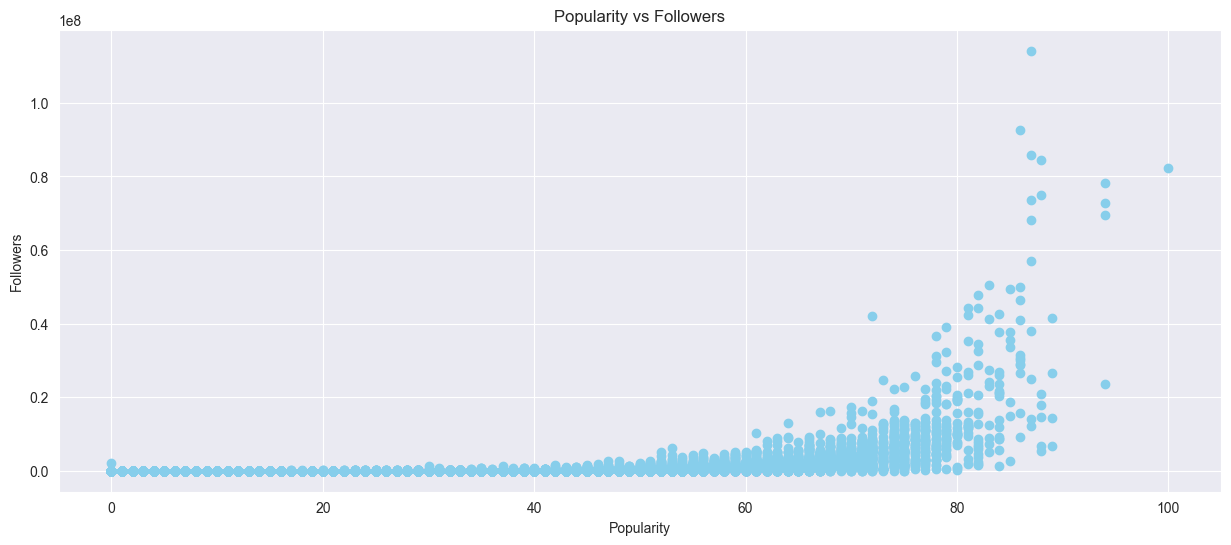

In [4]:
#Scatter plot of popularity vs followers
plt.figure(figsize=(15, 6))
plt.scatter(artists_dataset['popularity'], artists_dataset['followers'], color='skyblue')
plt.xlabel('Popularity')
plt.ylabel('Followers')
plt.title('Popularity vs Followers')

In [6]:
# Compute the correlation matrix for the popularity and followers columns
corr = artists_dataset[['popularity', 'followers']].corr()

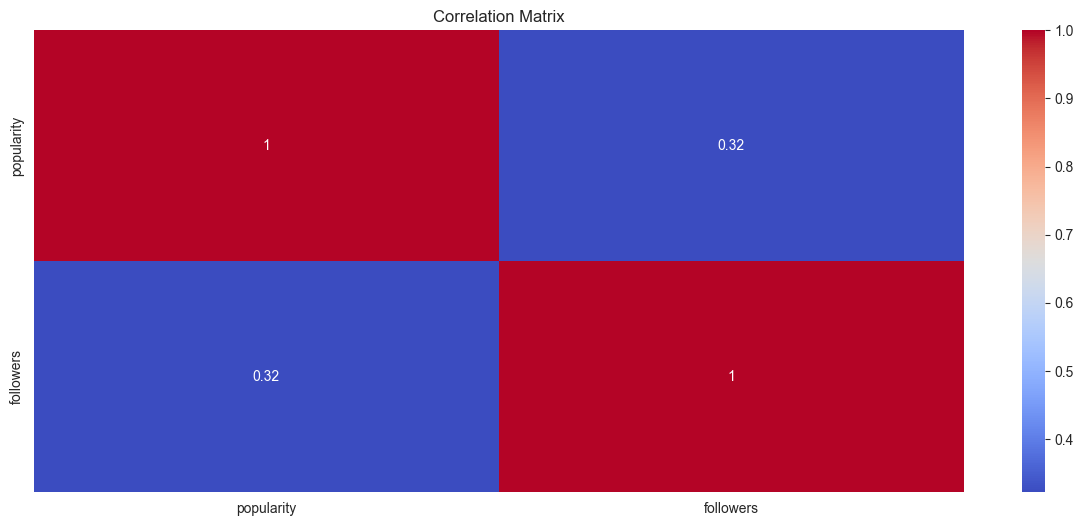

In [7]:
# Heatmap of artists_dataset
plt.figure(figsize=(15, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Tracks Dataset

In [4]:
# Now let's check if we have duplicate names
duplicated_rows = tracks_dataset[tracks_dataset.duplicated('name', keep=False)]
duplicated_rows

,id,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,...,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_beats,n_bars,genre,year,month,day
6,7MXVkk9YMctZqd1Srtv4MB,Starboy,230453,True,93,The Weeknd;Daft Punk,Starboy,0.679,0.5870,7,...,0.338,1.000,0.608,0.605,706.0,176.0,['pop'],2016,11.0,25.0
8,3USxtqRwSYz57Ewm6wWRMp,Heat Waves,238805,False,92,Glass Animals,Dreamland,0.761,0.5250,11,...,0.304,1.000,0.404,0.420,316.0,78.0,"['indie-pop', 'indie', 'pop']",2020,8.0,7.0
10,4Dvkj6JhhA12EX05fT7y2e,As It Was,167303,False,92,Harry Styles,Harry's House,0.520,0.7310,6,...,0.510,1.000,0.156,0.357,474.0,118.0,['pop'],2022,5.0,20.0
11,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,200040,False,92,The Weeknd,After Hours,0.514,0.7300,1,...,0.875,1.000,0.000,0.152,569.0,141.0,['pop'],2020,3.0,20.0
13,6UelLqGlWMcVH1E5c4H7lY,Watermelon Sugar,174000,False,91,Harry Styles,Fine Line,0.548,0.8160,0,...,0.217,1.000,0.491,0.533,273.0,69.0,['pop'],2019,12.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81204,5WbOIsOORBkqyIaXOV67df,System,239893,False,0,Black Uhuru,Unification,0.821,0.4200,0,...,0.016,1.000,0.499,0.423,646.0,162.0,['dub'],1998,6.0,20.0
81205,5WbFMsjJondIa0jQBwoBlt,Я встретил Вас,256640,False,0,Сергей Захаров,Вечерний звон,0.298,0.3450,7,...,0.242,0.574,0.489,0.446,336.0,83.0,['romance'],1996,6.0,11.0
81207,5WXN273AMH11PQuT4Yk2uN,Blind,212285,False,0,Chronic Law,Blind,0.690,0.5130,0,...,0.636,0.817,0.368,0.449,515.0,129.0,['j-dance'],2020,12.0,25.0
81214,5X8oinKsFkPHuHvFMPB5MH,"Rudolph, The Red-Nosed Reindeer",184213,False,0,The Smithereens,Alternative Christmas 2022,0.380,0.9000,7,...,0.165,0.950,0.798,0.904,435.0,108.0,['power-pop'],2022,10.0,20.0


In [5]:
ids = duplicated_rows[duplicated_rows.duplicated('id', keep=False)]
ids

,id,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,...,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_beats,n_bars,genre,year,month,day


We have 24074 rows with duplicated names and different ids, hence we have two possibilities but also different ids and differences in other attributes

In [77]:
#Among the songs with duplicated names drop keep the ones with the highest popularity and drop the others
cleaned_dataset = tracks_dataset.sort_values(by='popularity', ascending=False).drop_duplicates(subset='name', keep='first')


#Now drop the ones with duplicated ids
cleaned_dataset = cleaned_dataset.drop_duplicates(subset='id', keep='first')

cleaned_dataset

,id,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,...,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_beats,n_bars,genre,year,month,day
0,45OX2jjEw1l7lOFJfDP9fv,MONEY,168227,False,95,LISA,LALISA,0.826,0.55300,1,...,0.789,0.989,0.043,0.253,381.0,95.0,"['k-pop', 'pop']",2021,9.0,10.0
2,2bRKxuH1o7pTmb1y4GfdEc,Clean White Noise - Loopable with no fade,90228,False,94,White Noise Baby Sleep;White Noise for Babies,Best White Noise for Baby Sleep - Loopable wit...,0.000,0.00342,8,...,0.000,0.000,0.000,0.116,0.0,0.0,['sleep'],2017,1.0,8.0
3,4uUG5RXrOk84mYEfFvj3cK,I'm Good (Blue),175238,True,94,David Guetta;Bebe Rexha,I'm Good (Blue),0.561,0.96500,7,...,0.808,0.789,0.898,0.773,368.0,91.0,['pop'],2022,8.0,26.0
1,5XeFesFbtLpXzIVDNQP22n,I Wanna Be Yours,183956,False,94,Arctic Monkeys,AM,0.464,0.41700,0,...,0.097,1.000,0.545,0.533,202.0,50.0,"['indie', 'garage', 'rock']",2013,9.0,9.0
4,0WtM2NBVQNNJLh6scP13H8,Calm Down (with Selena Gomez),239317,False,93,Rema;Selena Gomez,Calm Down (with Selena Gomez),0.801,0.80600,11,...,0.492,1.000,0.593,0.597,424.0,105.0,['pop'],2022,8.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76389,7yOIaeHJ17V5ZUE8pRAd7b,"Cuddle Up, Cozy Down Christmas",219169,False,0,Dolly Parton;Michael Bublé,Merry Christmas,0.658,0.51500,1,...,0.506,0.802,0.549,0.573,399.0,99.0,['country'],2022,10.0,14.0
76387,039sj87NWcViw10cfxBIsv,"Lyric Pieces III, Op. 43 (Excerpts): No. 6, Ti...",155080,False,0,Edvard Grieg;Una Bourne,"Mozart, Liszt & Others: Piano Works",0.267,0.17400,6,...,0.168,0.189,0.613,0.487,229.0,57.0,['classical'],2022,10.0,7.0
76386,3eJBKLhpOauQJlgoOSPErD,York - Original Mix,476675,False,0,Christian Löffler,York,0.696,0.63400,11,...,0.467,0.960,0.562,0.629,933.0,234.0,['minimal-techno'],2015,5.0,3.0
76384,39jBzZcMJMxhAhPg8SYvnj,"Carnaval, Op. 9: No. 21, Marche des Davidsbünd...",209840,False,0,Robert Schumann;Pavel Nersessian,"Schumann, Poulenc & Others: Piano Works (Live ...",0.416,0.21100,8,...,0.124,0.203,0.393,0.485,463.0,115.0,"['german', 'classical']",2022,10.0,7.0


In the end we decided to drop the rows with duplicated names and keep the ones with the highest popularity.

In [7]:
tracks_dataset

,id,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,...,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_beats,n_bars,genre,year,month,day
0,45OX2jjEw1l7lOFJfDP9fv,MONEY,168227,False,95,LISA,LALISA,0.826,0.55300,1,...,0.789,0.989,0.043,0.253,381.0,95.0,"['k-pop', 'pop']",2021,9.0,10.0
1,5XeFesFbtLpXzIVDNQP22n,I Wanna Be Yours,183956,False,94,Arctic Monkeys,AM,0.464,0.41700,0,...,0.097,1.000,0.545,0.533,202.0,50.0,"['indie', 'garage', 'rock']",2013,9.0,9.0
2,2bRKxuH1o7pTmb1y4GfdEc,Clean White Noise - Loopable with no fade,90228,False,94,White Noise Baby Sleep;White Noise for Babies,Best White Noise for Baby Sleep - Loopable wit...,0.000,0.00342,8,...,0.000,0.000,0.000,0.116,0.0,0.0,['sleep'],2017,1.0,8.0
3,4uUG5RXrOk84mYEfFvj3cK,I'm Good (Blue),175238,True,94,David Guetta;Bebe Rexha,I'm Good (Blue),0.561,0.96500,7,...,0.808,0.789,0.898,0.773,368.0,91.0,['pop'],2022,8.0,26.0
4,0WtM2NBVQNNJLh6scP13H8,Calm Down (with Selena Gomez),239317,False,93,Rema;Selena Gomez,Calm Down (with Selena Gomez),0.801,0.80600,11,...,0.492,1.000,0.593,0.597,424.0,105.0,['pop'],2022,8.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81220,1nSYUQngGS5foiagiilbYU,Singles You Up,182693,False,0,Jordan Davis,Mientras hago aromaterapia,0.634,0.90300,7,...,0.137,1.000,0.439,0.533,296.0,74.0,['country'],2022,10.0,14.0
81221,1nU1tlW9ccptgRLfgq05I3,"Schlagzeile groß, Hirn zu klein",255093,False,0,Frei.Wild,Feinde deiner Feinde (Gold Edition),0.412,0.98400,8,...,0.120,0.762,0.558,0.509,818.0,205.0,['german'],2013,4.0,19.0
81222,72ZHywsIxzF1ZkNlMyhsqt,"Ding! Dong! The Witch Is Dead (From ""The Wizar...",179035,False,0,The Countdown Kids,Happy Halloween! (Spooky Favorites for Kids),0.741,0.93700,11,...,0.826,0.959,0.715,0.532,352.0,87.0,['children'],2022,10.0,14.0
81223,5Wt0gIt7RrXz5mJj5pslLC,Zenitsu Theme V2 (Thunder Clap and Flash!),137948,False,0,Samuel Kim,Demon Slayer: Epic Collection,0.507,0.80300,0,...,0.545,1.000,0.791,0.703,263.0,67.0,['anime'],2021,5.0,21.0


Now we decided to drop all the useless columns, such as track_number, disc_number, album_total_tracks, album_release_date_precision

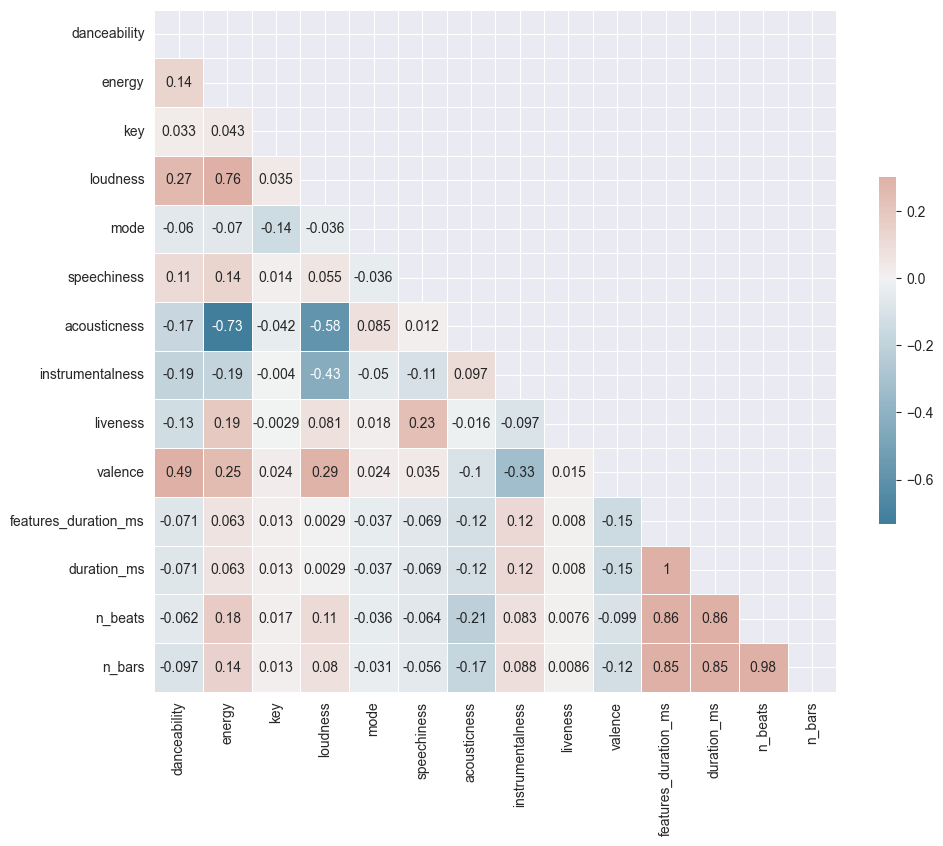

In [8]:
# Define the columns of interest
columns_of_interest = ['danceability', 'energy', 'key', 'loudness', 'mode', 
                       'speechiness', 'acousticness', 'instrumentalness', 
                       'liveness', 'valence', 'features_duration_ms', 'duration_ms',
                       'n_beats', 'n_bars']

# Compute the correlation matrix for the columns of interest
corr = tracks_dataset[columns_of_interest].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

### Distribution of durations_ms and features_duration_ms

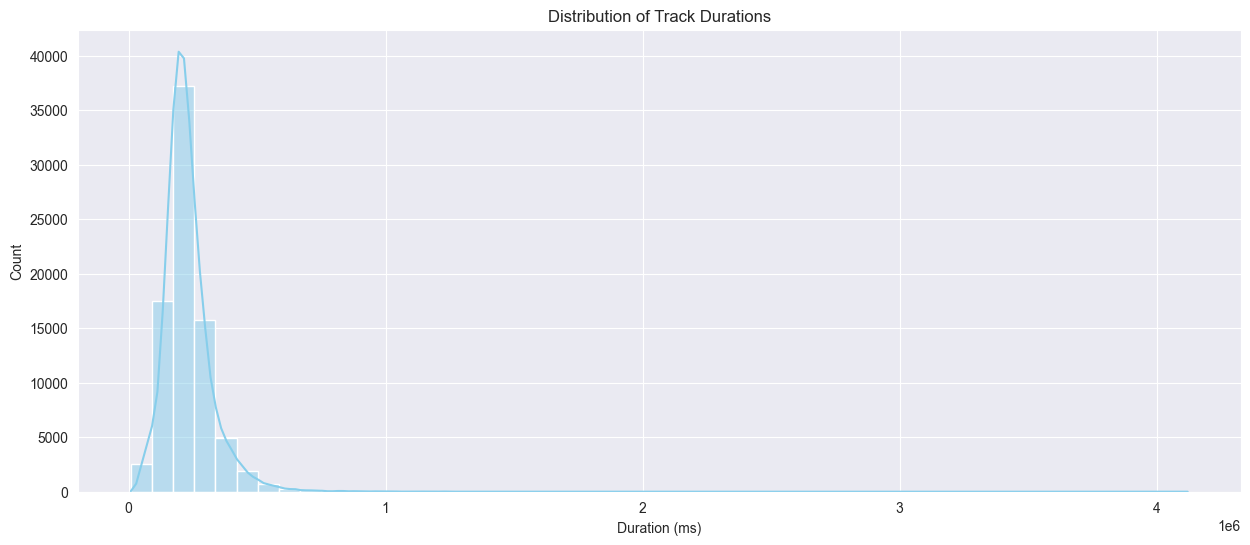

In [3]:
# Plot the distribution of the 'duration_ms' column
plt.figure(figsize=(15, 6))
sns.histplot(tracks_dataset['duration_ms'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Track Durations')
plt.xlabel('Duration (ms)')
plt.ylabel('Count')
plt.show()

In [8]:
# Print the 5 shortest tracks
tracks_dataset.nsmallest(5, 'duration_ms')

,id,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,...,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_beats,n_bars,genre,year,month,day
78920,6hsyfegVY5yklJneM40mWi,The Exorsism Begins...,8586,False,0,Leila Bela,Angra Manyu,0.000,0.0400,8,...,0.000,0.000,0.108,0.420,0.0,0.0,['iranian'],2001,1.0,1.0
76163,38Ogh3rsHba83kXx13gbKs,V-4,13386,False,0,Leila Bela,Angra Manyu,0.000,0.2240,11,...,0.000,0.000,0.491,0.367,0.0,0.0,['iranian'],2001,1.0,1.0
78281,1HVjSh7scH1PaPiLjy2LEu,Screams for a Finale! (feat. Leila's Opera Class),15800,False,0,Leila Bela;Leila's Opera Class,Angra Manyu,0.251,0.5080,5,...,0.833,0.931,0.000,0.107,44.0,13.0,['iranian'],2001,1.0,1.0
81057,5YKCM3jbJ8lqUXUwfU7KwZ,"Andante in C Major, K. 1a",17453,False,0,Wolfgang Amadeus Mozart;Ingrid Haebler,Mozart: The Complete Piano Sonatas,0.467,0.0301,2,...,0.077,0.533,0.023,0.352,22.0,4.0,['classical'],2022,10.0,14.0
78666,1T5QvLF9lO4HO3OZQbaX9p,"Carnaval, Op. 9: No. 20, Pause (Live in Japan,...",17826,False,0,Robert Schumann;Pavel Nersessian,"Schumann, Poulenc & Others: Piano Works (Live ...",0.372,0.2780,8,...,0.060,1.000,0.716,0.633,25.0,5.0,"['german', 'classical']",2022,10.0,7.0


In [6]:
# Print the 5 longest tracks
tracks_dataset.nlargest(5, 'duration_ms')

,id,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,...,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_beats,n_bars,genre,year,month,day
27744,2QfFLpSGF1T1pY6tq4kD7Z,Ocean Waves Sounds,4120258,False,43,Ocean Sounds,Ocean Waves Sounds to Relax and Sleep,0.0797,0.995000,1,...,0.050,0.324,0.000,0.000,6484.0,2170.0,['sleep'],2010,7.0,16.0
45072,2EnZf7wbFv7ST4CJ3EvNzT,Ruido Rosa Puro - Una Hora Versión,3601693,False,29,El Ruido Blanco,Ruido Blanco para el bebé: sonidos relajantes ...,0.0000,0.000020,1,...,0.000,0.000,0.004,0.144,0.0,0.0,['world-music'],2012,5.0,21.0
42274,3Y4VTVeGZhchi8mZdAfmfD,Vacuum Cleaner White Noise,3600120,False,32,Vacuum Cleaner White Noise,Colic Sweep Vacuum Cleaner White Noise (The Be...,0.0989,0.013400,8,...,0.020,0.490,0.006,0.353,5966.0,1501.0,['sleep'],2007,5.0,14.0
37035,5m00VnXlz8yRKmCXVgJCEa,Electric Fan (Sound Masking Fan),3600014,False,36,Electric Dreams,Electric Fan (Sound Masking Fan),0.0000,0.000512,11,...,0.000,0.000,0.168,0.360,0.0,0.0,['sleep'],2011,12.0,20.0
42560,1PcyypJ70gm6CxTKQvCQiX,Der ultimative Wendler Hitmix XL,2959346,False,31,Michael Wendler,Der ultimative Wendler Hitmix,0.6080,0.919000,10,...,0.806,0.968,0.494,0.405,6420.0,1615.0,['party'],2016,6.0,17.0


Looking at the data, we can see that the longest tracks are white noise tracks or ocean waves sounds. Maybe the shortest ones are not songs, but we can't be sure. 

### Explicit distribution

The explicit value is highly unbalanced with 91% of the tracks being non-explicit.

### Popularity distribution

In [12]:
tracks_dataset

,id,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,...,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_beats,n_bars,genre,year,month,day
0,45OX2jjEw1l7lOFJfDP9fv,MONEY,168227,False,95,LISA,LALISA,0.826,0.55300,1,...,0.789,0.989,0.043,0.253,381.0,95.0,"['k-pop', 'pop']",2021,9.0,10.0
1,5XeFesFbtLpXzIVDNQP22n,I Wanna Be Yours,183956,False,94,Arctic Monkeys,AM,0.464,0.41700,0,...,0.097,1.000,0.545,0.533,202.0,50.0,"['indie', 'garage', 'rock']",2013,9.0,9.0
2,2bRKxuH1o7pTmb1y4GfdEc,Clean White Noise - Loopable with no fade,90228,False,94,White Noise Baby Sleep;White Noise for Babies,Best White Noise for Baby Sleep - Loopable wit...,0.000,0.00342,8,...,0.000,0.000,0.000,0.116,0.0,0.0,['sleep'],2017,1.0,8.0
3,4uUG5RXrOk84mYEfFvj3cK,I'm Good (Blue),175238,True,94,David Guetta;Bebe Rexha,I'm Good (Blue),0.561,0.96500,7,...,0.808,0.789,0.898,0.773,368.0,91.0,['pop'],2022,8.0,26.0
4,0WtM2NBVQNNJLh6scP13H8,Calm Down (with Selena Gomez),239317,False,93,Rema;Selena Gomez,Calm Down (with Selena Gomez),0.801,0.80600,11,...,0.492,1.000,0.593,0.597,424.0,105.0,['pop'],2022,8.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81220,1nSYUQngGS5foiagiilbYU,Singles You Up,182693,False,0,Jordan Davis,Mientras hago aromaterapia,0.634,0.90300,7,...,0.137,1.000,0.439,0.533,296.0,74.0,['country'],2022,10.0,14.0
81221,1nU1tlW9ccptgRLfgq05I3,"Schlagzeile groß, Hirn zu klein",255093,False,0,Frei.Wild,Feinde deiner Feinde (Gold Edition),0.412,0.98400,8,...,0.120,0.762,0.558,0.509,818.0,205.0,['german'],2013,4.0,19.0
81222,72ZHywsIxzF1ZkNlMyhsqt,"Ding! Dong! The Witch Is Dead (From ""The Wizar...",179035,False,0,The Countdown Kids,Happy Halloween! (Spooky Favorites for Kids),0.741,0.93700,11,...,0.826,0.959,0.715,0.532,352.0,87.0,['children'],2022,10.0,14.0
81223,5Wt0gIt7RrXz5mJj5pslLC,Zenitsu Theme V2 (Thunder Clap and Flash!),137948,False,0,Samuel Kim,Demon Slayer: Epic Collection,0.507,0.80300,0,...,0.545,1.000,0.791,0.703,263.0,67.0,['anime'],2021,5.0,21.0


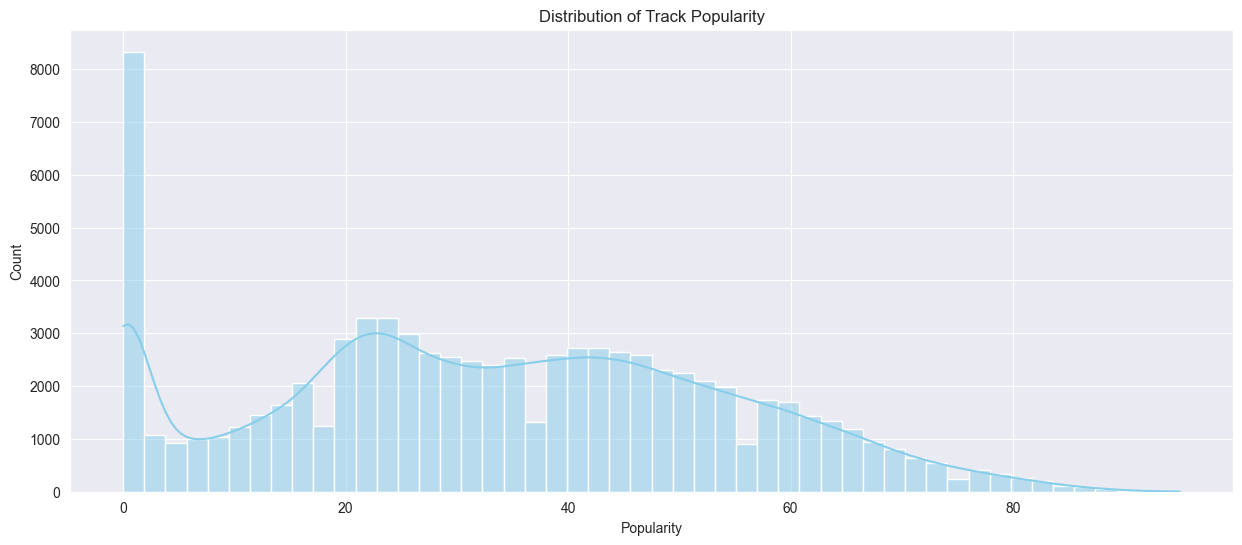

In [11]:
# Plot the distribution of the 'popularity' column
plt.figure(figsize=(15, 6))
sns.histplot(tracks_dataset['popularity'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Track Popularity')
plt.xlabel('Popularity')
plt.ylabel('Count')
plt.show()

In [21]:
# Tell me how many songs with popularity 0 we have
tracks_dataset[tracks_dataset['popularity'] == 0].shape[0]

7249

In [13]:
 # Distribution of popularity
tracks_dataset['popularity'].describe()

count    81225.000000
mean        33.377642
std         20.680692
min          0.000000
25%         19.000000
50%         33.000000
75%         49.000000
max         95.000000
Name: popularity, dtype: float64

### Danceability distribution

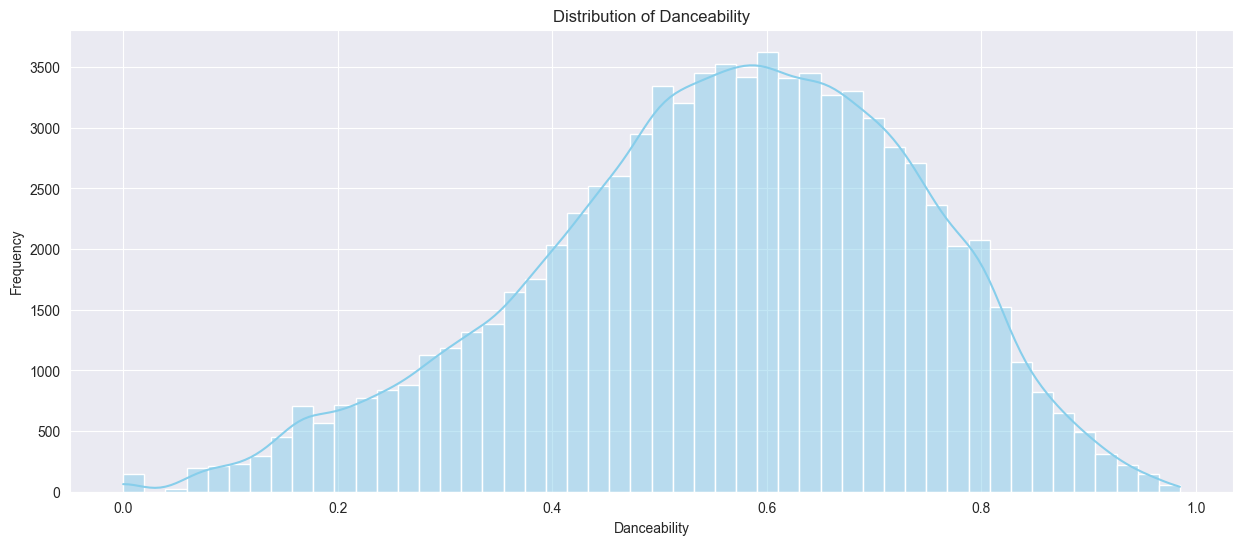

In [23]:
# Plot the distribution of the 'danceability' column
plt.figure(figsize=(15, 6))
sns.histplot(tracks_dataset['danceability'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Danceability')
plt.xlabel('Danceability')
plt.ylabel('Frequency')
plt.show()

### Energy distribution

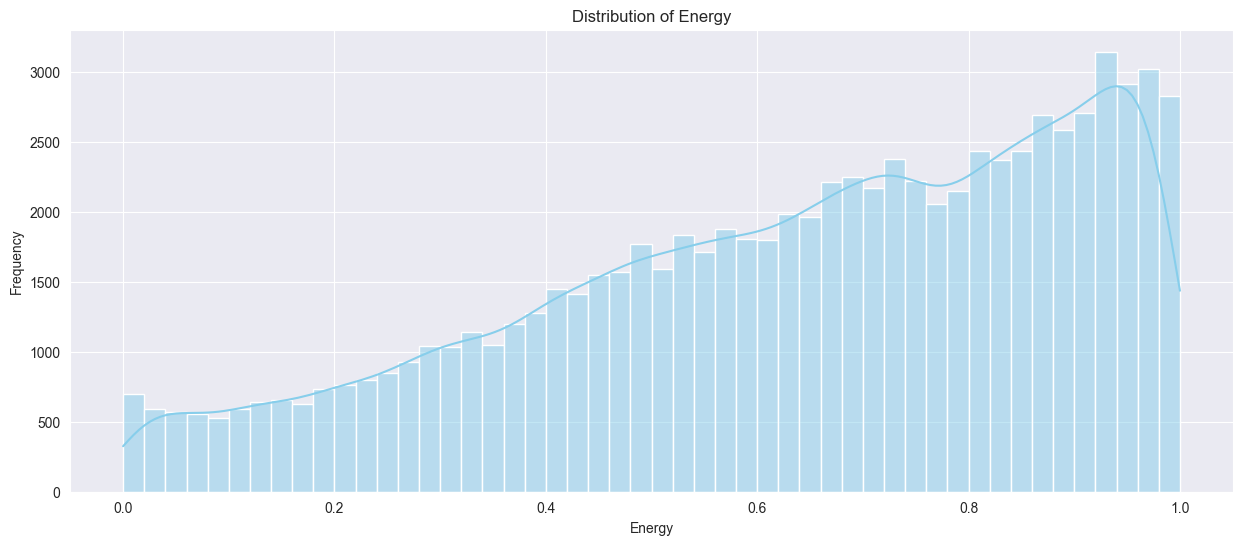

In [24]:
# Plot the distribution of the 'energy' column
plt.figure(figsize=(15, 6))
sns.histplot(tracks_dataset['energy'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Energy')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.show()

### Loudness distribution

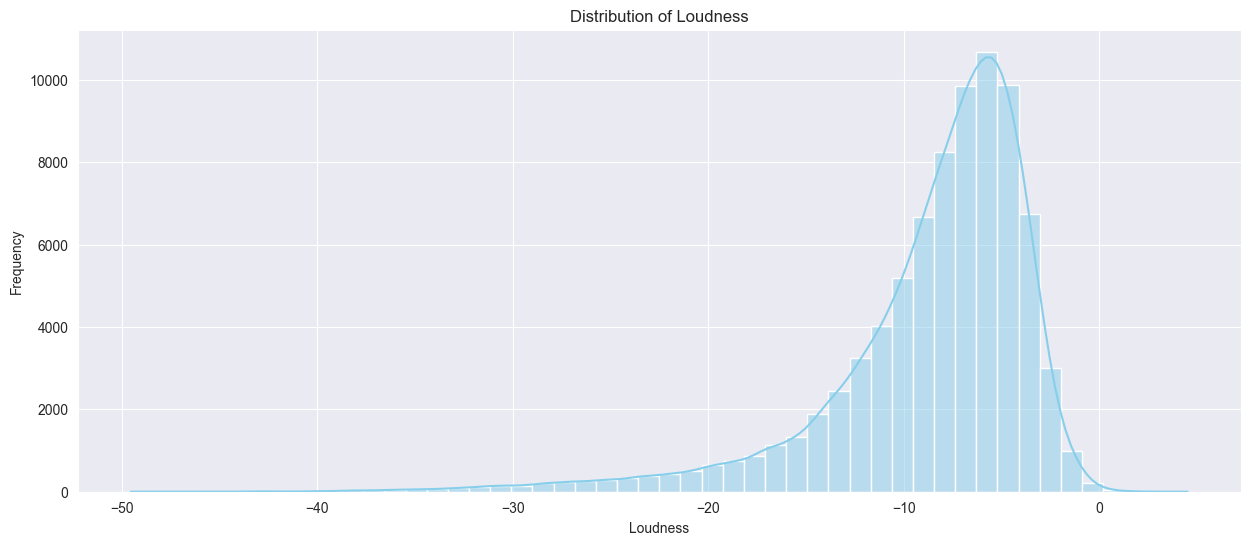

In [26]:
# Plot the distribution of the 'loudness' column
plt.figure(figsize=(15, 6))
sns.histplot(tracks_dataset['loudness'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Loudness')
plt.xlabel('Loudness')
plt.ylabel('Frequency')
plt.show()

### Speechiness distribution

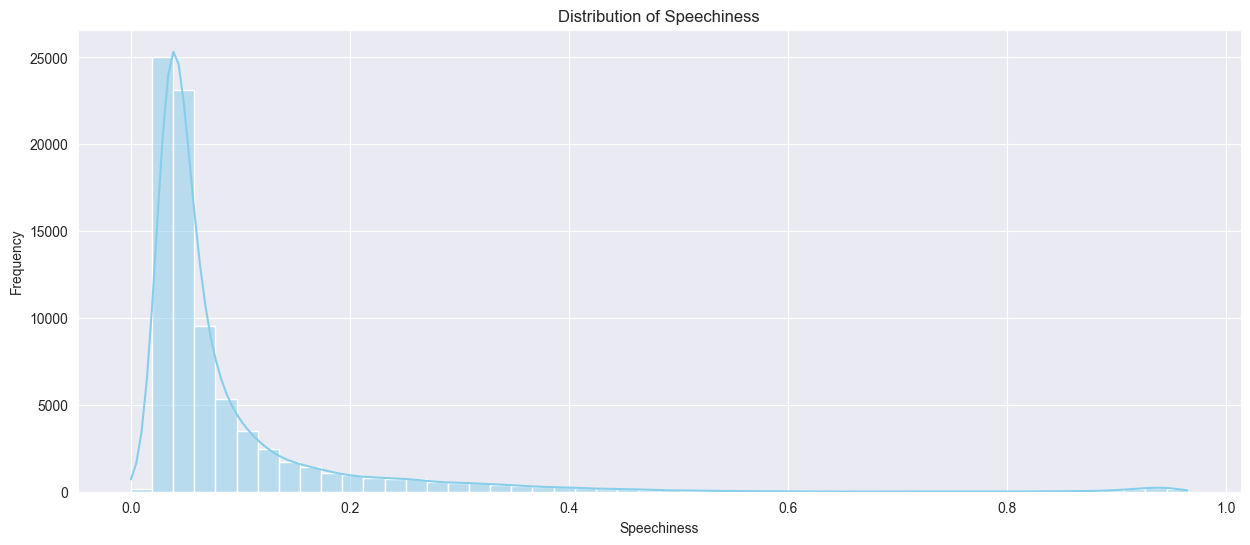

In [27]:
# Plot the distribution of the 'speechiness' column
plt.figure(figsize=(15, 6))
sns.histplot(tracks_dataset['speechiness'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Speechiness')
plt.xlabel('Speechiness')
plt.ylabel('Frequency')
plt.show()

### Liveness distribution

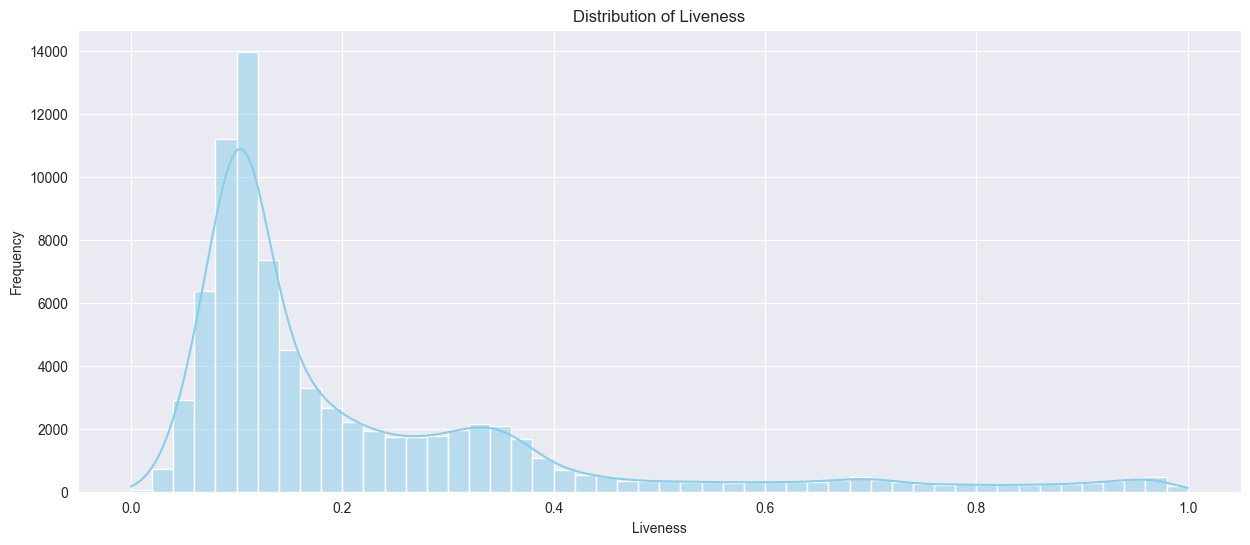

In [32]:
# Plot the distribution of the 'liveness' column
plt.figure(figsize=(15, 6))
sns.histplot(tracks_dataset['liveness'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Liveness')
plt.xlabel('Liveness')
plt.ylabel('Frequency')
plt.show()

### Valence distribution

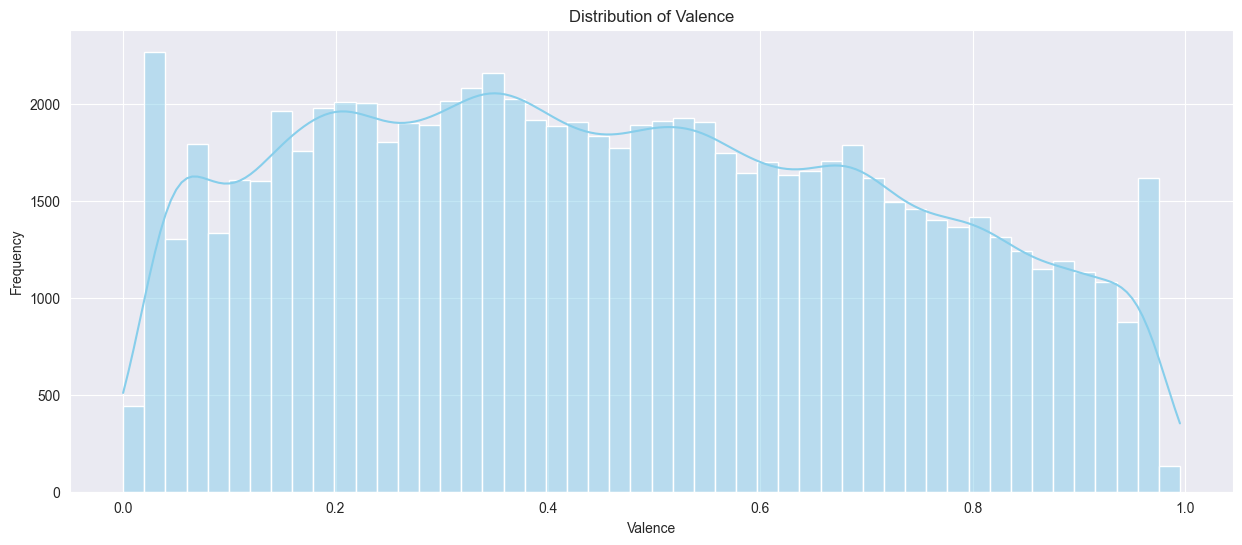

In [33]:
# Plot the distribution of the 'valence' column
plt.figure(figsize=(15, 6))
sns.histplot(tracks_dataset['valence'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Valence')
plt.xlabel('Valence')
plt.ylabel('Frequency')
plt.show()

 ### Acousticness distribution

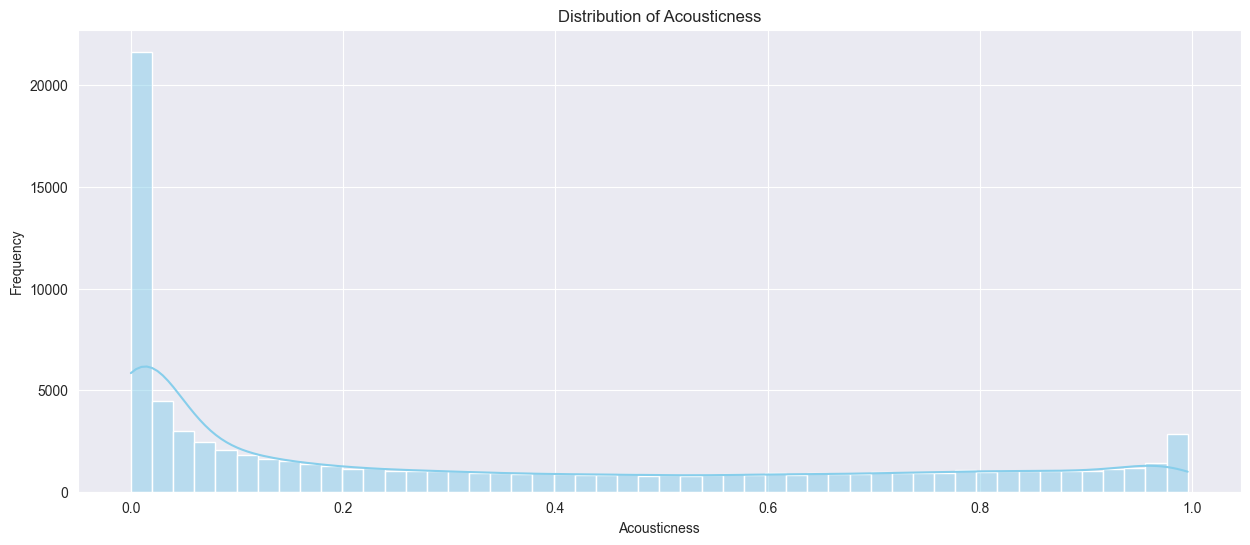

In [28]:
# Plot the distribution of the 'acousticness' column
plt.figure(figsize=(15, 6))
sns.histplot(tracks_dataset['acousticness'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Acousticness')
plt.xlabel('Acousticness')
plt.ylabel('Frequency')
plt.show()

### Key distribution

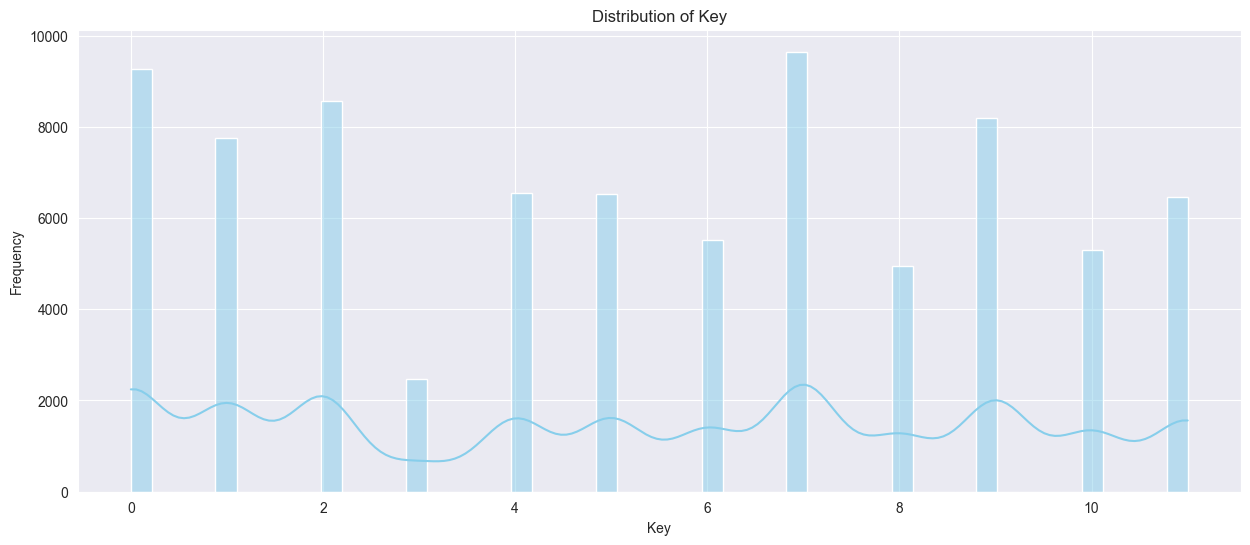

In [5]:
# Plot the distribution of the 'key' column
plt.figure(figsize=(15, 6))
sns.histplot(tracks_dataset['key'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Key')
plt.xlabel('Key')
plt.ylabel('Frequency')
plt.show()

In my opinion the key column should be transformed into a categorical variable, as it is a nominal variable. Notably, the keys of C (0) and G (7) are the most common, with 9,275 and 9,645 tracks, respectively. This could indicate a natural affinity or a historical preference for compositions in these keys, possibly due to their harmonic simplicity or compatibility with common musical instruments.


### Tempo distribution

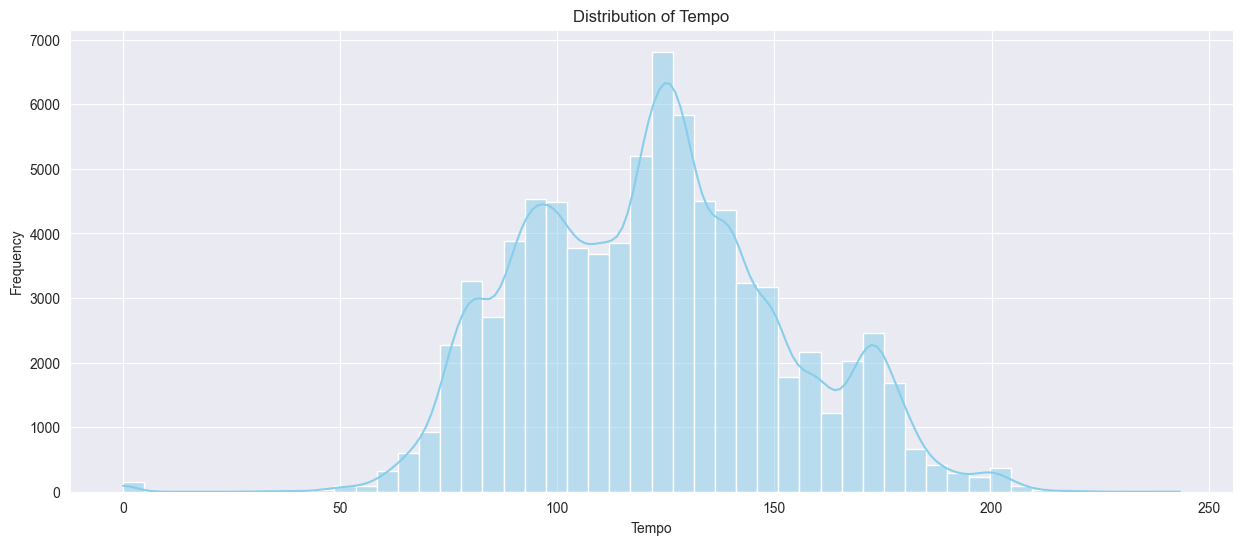

In [7]:
# Plot the distribution of the 'tempo' column
plt.figure(figsize=(15, 6))
sns.histplot(tracks_dataset['tempo'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Tempo')
plt.xlabel('Tempo')
plt.ylabel('Frequency')
plt.show()

In [11]:
# Print the 5 slowest tracks
tracks_dataset.nsmallest(200, 'tempo')

,id,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,...,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_beats,n_bars,genre,year,month,day
2,2bRKxuH1o7pTmb1y4GfdEc,Clean White Noise - Loopable with no fade,90228,False,94,White Noise Baby Sleep;White Noise for Babies,Best White Noise for Baby Sleep - Loopable wit...,0.000,0.00342,8,...,0.000,0.000,0.000,0.116,0.0,0.0,['sleep'],2017,1.0,8.0
3734,5pGBDKBaR63vuJ4g8ialcU,Deep Sleep Recovery Noise,63000,False,68,Water Sound Natural White Noise,White Noise Spa – Calming Noises,0.000,0.03200,1,...,0.000,0.000,0.000,0.000,0.0,0.0,['sleep'],2020,2.0,25.0
3874,1VfdHjChKjH3cRgWVqDqyb,White Noise Relaxation for Calming Down Fussy ...,593754,False,68,White Noise Baby Sleep,White Noise for Sleeping Babies,0.000,0.37300,10,...,0.000,0.000,0.593,0.534,0.0,0.0,['sleep'],2015,3.0,27.0
4098,63kd4m3VFxcJjPVVtbVNAu,"Hello, Dolly!",147000,False,68,Louis Armstrong,"Hello, Dolly! (Remastered)",0.000,0.40500,0,...,0.000,0.000,0.297,0.482,0.0,0.0,['jazz'],1964,10.0,25.0
8611,1Kb2DqjHRvOcT5xeWtz3t5,Ferme Les Yeux,68493,False,61,Sylvain Chauveau,Des Plumes Dans La Tête,0.000,0.03230,2,...,0.000,0.000,0.000,0.000,0.0,0.0,['ambient'],2004,4.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,27An0sDvzMb7GM6pRE9ycF,Like Before,135903,False,43,Ole-Bjørn Talstad,Like Before,0.560,0.03450,11,...,0.000,0.050,0.431,0.273,102.0,26.0,['piano'],2021,11.0,19.0
75715,4gEDWJKX2Lykhu6CtMA4O2,DARKDARKNIGHT,721801,False,0,Hadi Bastani,COLD HOUR,0.114,0.00900,1,...,0.076,0.571,0.165,0.380,754.0,190.0,['iranian'],2021,12.0,17.0
66850,4o1fv1iAZ5wesZKXFQXjMZ,South,148733,True,13,Baron Vaughn,Blaxistential Crisis,0.465,0.61500,6,...,0.080,0.600,0.381,0.366,212.0,53.0,['comedy'],2016,10.0,7.0
64471,1po3putIfXVS71jPA71v6J,Kelvingrove (The Summons),199493,False,16,Jon Sarta,The Catholic Music Project IX: Piano Glory And...,0.455,0.04010,5,...,0.017,0.453,0.874,0.904,246.0,81.0,['disney'],2008,7.0,25.0


Between the slowest tracks we have some white noise tracks, and some ocean waves sounds. For real songs, the slowest one is a song with 0.0 bpm, which is not possible. We have to make a choice in the data preparation phase.

### Start_of_fade_out distribution

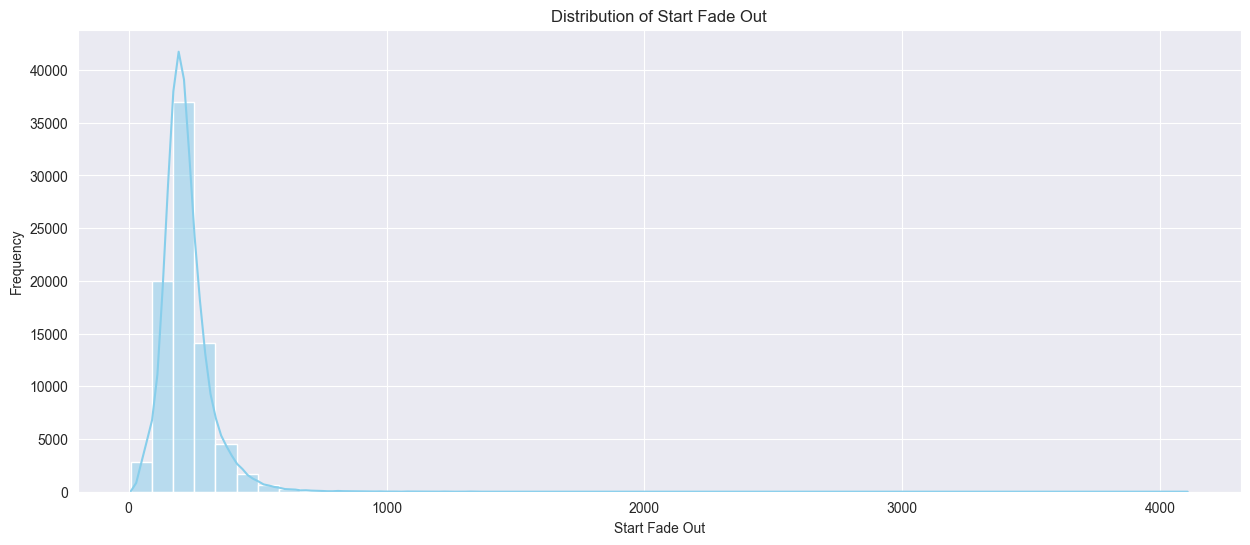

In [13]:
# Plot the distribution of the 'start_fade_out' column
plt.figure(figsize=(15, 6))
sns.histplot(tracks_dataset['start_of_fade_out'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Start Fade Out')
plt.xlabel('Start Fade Out')
plt.ylabel('Frequency')
plt.show()

### time_signature distribution

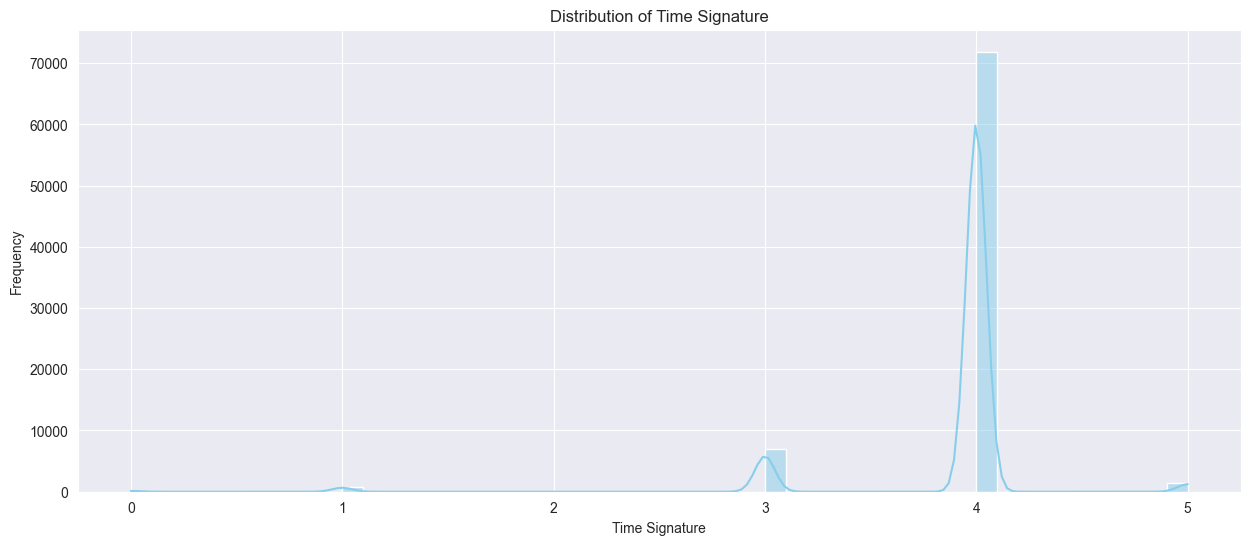

In [20]:
# Plot the distribution of the 'time_signature' column
plt.figure(figsize=(15, 6))
sns.histplot(tracks_dataset['time_signature'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Time Signature')
plt.xlabel('Time Signature')
plt.ylabel('Frequency')
plt.show()

### n_bars distribution

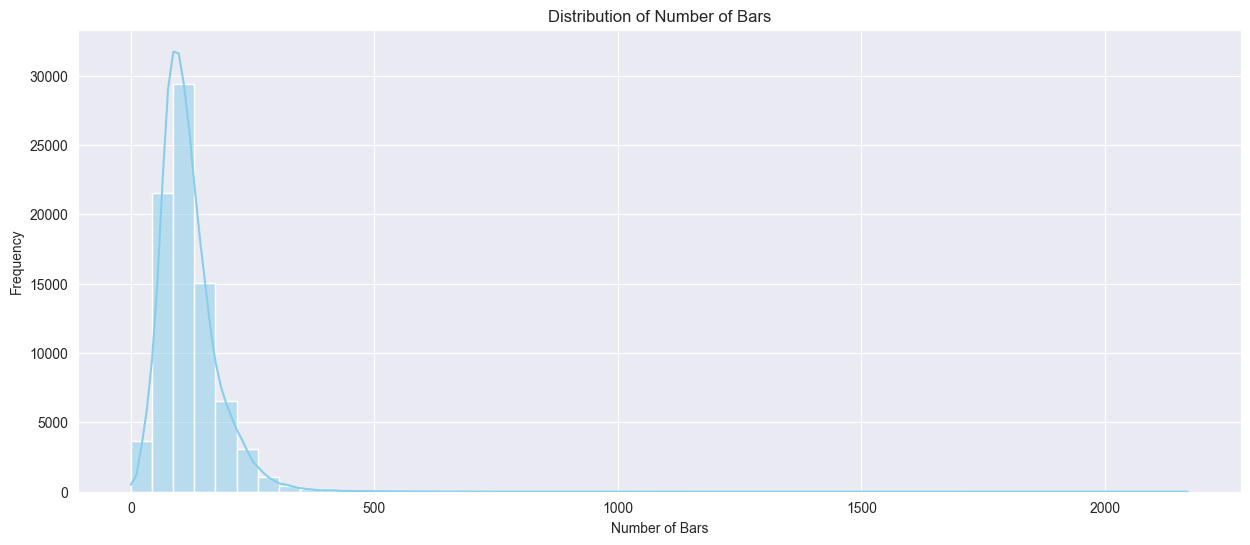

In [23]:
# Plot the distribution of the 'n_bars' column
plt.figure(figsize=(15, 6))
sns.histplot(tracks_dataset['n_bars'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Number of Bars')
plt.xlabel('Number of Bars')
plt.ylabel('Frequency')
plt.show()

### Mode distribution

In [6]:
# How many tracks are in major and minor keys in percentage
mode_counts = tracks_dataset['mode'].value_counts(normalize=True) * 100
mode_counts

mode
1    63.257618
0    36.742382
Name: proportion, dtype: float64

### Instrumentalness distribution

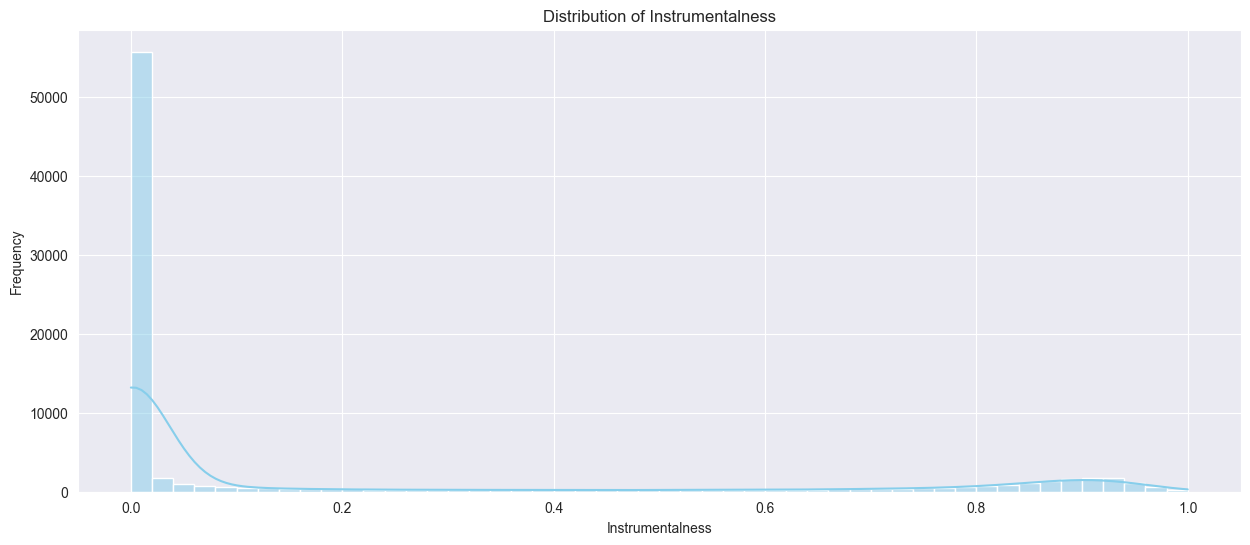

In [29]:
# Plot the distribution of the 'instrumentalness' column
plt.figure(figsize=(15, 6))
sns.histplot(tracks_dataset['instrumentalness'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Instrumentalness')
plt.xlabel('Instrumentalness')
plt.ylabel('Frequency')
plt.show()

### Loudness vs Energy

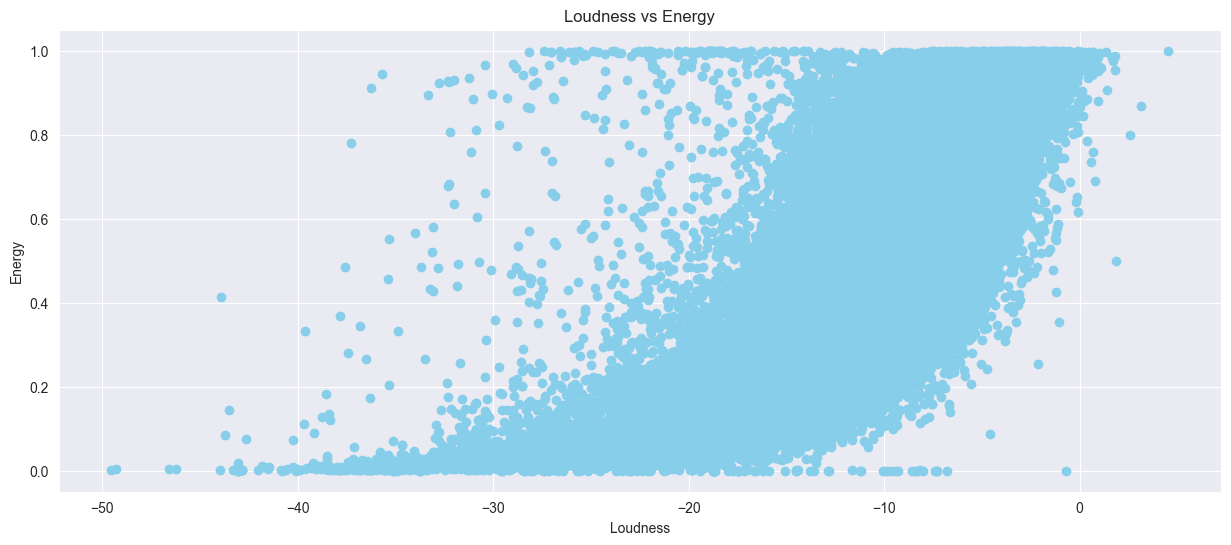

In [31]:
# Scatter plot of 'loudness' vs 'energy'
plt.figure(figsize=(15, 6))
plt.scatter(tracks_dataset['loudness'], tracks_dataset['energy'], color='skyblue')
plt.xlabel('Loudness')
plt.ylabel('Energy')
plt.title('Loudness vs Energy')
plt.show()

### Distribution per seasons

In [36]:
def get_season(month):
    # Assuming Northern Hemisphere seasonality
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Apply the function to the 'month' column to create a 'season' column
data = tracks_dataset.copy()
data['season'] = data['month'].apply(get_season)

# Count the number of songs in each season
songs_per_season = data['season'].value_counts()

songs_per_season

season
Fall      24580
Winter    18346
Summer    16846
Spring    16541
Name: count, dtype: int64

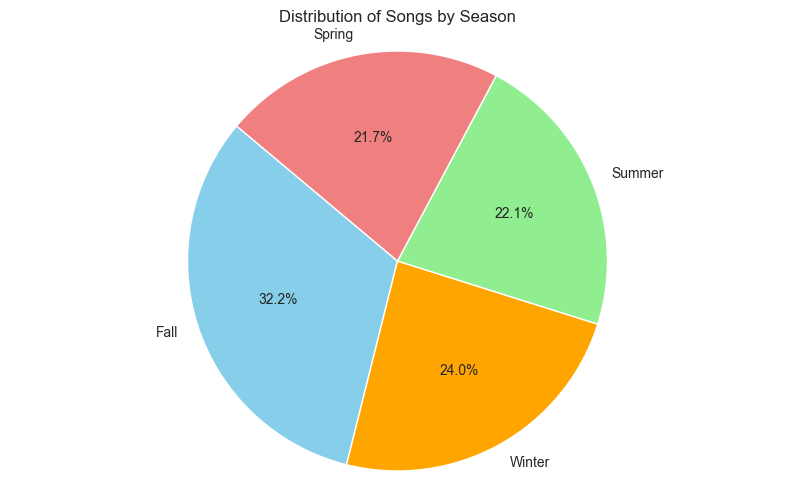

In [37]:
# Plot the number of songs in each season, with a pie chart
plt.figure(figsize=(10, 6))
plt.pie(songs_per_season, labels=songs_per_season.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'orange', 'lightgreen', 'lightcoral'])
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Songs by Season')
plt.show()

In [38]:
seasonal_means = data.groupby('season')[['valence', 'energy', 'danceability', 'tempo']].mean()
seasonal_means

,valence,energy,danceability,tempo
season,,,,
Fall,0.452734,0.626049,0.556891,121.499167
Spring,0.458218,0.641364,0.566347,122.483035
Summer,0.463813,0.652527,0.571660,122.765815
Winter,0.465676,0.621384,0.550702,122.111556


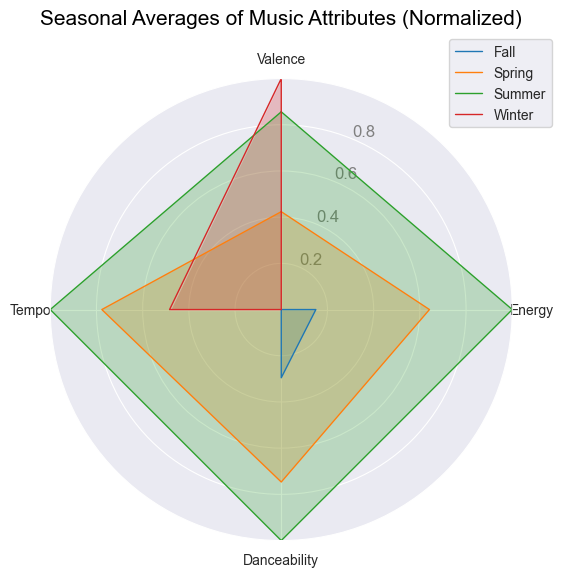

In [43]:
# Normalize the data for better comparison
scaled_features = (seasonal_means - seasonal_means.min()) / (seasonal_means.max() - seasonal_means.min())

# Creating a radar plot for the scaled data
labels = np.array(['Valence', 'Energy', 'Danceability', 'Tempo'])
num_vars = len(labels)

# Calculate angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Plot setup
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Add each attribute to the radar plot
for idx, row in scaled_features.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=idx)
    ax.fill(angles, values, alpha=0.25)

# Add attribute labels
plt.xticks(angles[:-1], labels)

# Y-ticks
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=12)
plt.ylim(0,1)

plt.title('Seasonal Averages of Music Attributes (Normalized)', size=15, color='black', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.show()

## Time Series Dataset

# Possible join of the datasets

A way to join the datasets could be to merge the datasets on the 'name' column in the 'artists' dataset and the 'artists' column in the 'tracks' dataset. However, the 'artists' column in the 'tracks' dataset contains multiple artists separated by a semicolon. To join the datasets on the 'artists' column, we need to extract the primary artist's name from the 'artists' column in the 'tracks' dataset. We can then merge the datasets on the primary artist's name.

In [79]:
# Extract primary artist's name from the 'artists' column in the 'tracks' dataset
# Assuming the primary artist is the first listed in the 'artists' column
#tracks_dataset['primary_artist'] = tracks_dataset['artists'].apply(lambda x: x.split(';')[0])

# Merge the datasets on artist name
#merged_df = pd.merge(tracks_dataset, artists_dataset, how='left', left_on='primary_artist', right_on='name', suffixes=('_track', '_artist'))

# Drop the duplicated 'name' column and any other unnecessary columns from the merge
#merged_df = merged_df.drop(columns=['name_artist'])

#merged_df

However, this approach isn't perfect because the streams of the songs are distributed among all the artists as said by [spotify it's self](https://community.spotify.com/t5/Content-Questions/Two-main-artists-on-a-song/td-p/5826073). 

Then we can adopt a more inclusive approach and join for each artist linked in a track. This however, introduces complexity, as it requires expanding the tracks dataset to create a row for each artist-track combination before joining with the 'artists' dataset.


In [80]:
# Create a new DataFrame to hold the expanded artist-track combinations
#xpanded_tracks_df = tracks_dataset.assign(artists=tracks_dataset['artists'].str.split(';')).explode('artists')

# Strip leading and trailing spaces from the exploded 'artists' column to ensure clean matching
#expanded_tracks_df['artists'] = expanded_tracks_df['artists'].str.strip()

# Merge the expanded tracks dataset with the artists dataset on artist name
#expanded_merged_df = pd.merge(expanded_tracks_df, artists_dataset, how='left', left_on='artists', right_on='name', suffixes=('_track', '_artist'))

# Preview the newly merged dataset
#expanded_merged_df